# Сервис по продаже автомобилей с пробегом «Не бит, не крашен»

**Введение**

Данные для работы получены из файла `autos.csv`.

**Цель работы**

Разработать модель, определяющая рыночную стоимость автомобиля.

**Ход работы**

1. Загрузить данные
2. Изучить данные, выполнив предобработку.
3. Подготовить выборки дял обучения модели.
4. Обучить разные модели.
5. Проанализировать время обучения, время предсказания и качество моделей.
6. Проверить выбранную модель на тестовой выборке.

## Загрузка данных

Подключим необходимые библиотеки.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn.compose import make_column_transformer

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import (
    GridSearchCV,
    train_test_split
)

from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler
)

import lightgbm as lgb
import catboost as cb
from sklearn.metrics import mean_squared_error

import time

RANDOM_STATE = 42

Выгрузим данные в переменную `data`.

In [2]:
try:
    data = pd.read_csv('autos.csv')
except:
    data = pd.read_csv('/datasets/autos.csv')


data_1 = data
data.head(5)


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


## Предобработка и изучение данных

Информация о столбцах:

**Признаки**

* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* Repaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя

**Целевой признак**

* Price — цена (евро)

Перед тем как выполнять предобработку, избавимся от столбцов, которые не понадобятся в ходе обучения модели. Выделим уровни влияния столбцов перед удалением:

**&#128308; Высокое:**

* VehicleType
* RegistrationYear
* Power
* Model
* Kilometer
* Brand
* Repaired
* Gearbox
* FuelType

**&#128994; Низкое**

* DateCrawled
* RegistrationMonth
* DateCreated
* NumberOfPictures
* PostalCode
* LastSeen

Можно сразу избавиться от столбцов, которые будут мешать обучение модели, а именно со значением: **&#128994; Низкое**.

In [3]:
data = data.drop(['DateCrawled','RegistrationMonth','DateCreated','NumberOfPictures','PostalCode', 'LastSeen'], axis = 1)

Выведем информацию о данных.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354369 non-null  int64 
 1   VehicleType       316879 non-null  object
 2   RegistrationYear  354369 non-null  int64 
 3   Gearbox           334536 non-null  object
 4   Power             354369 non-null  int64 
 5   Model             334664 non-null  object
 6   Kilometer         354369 non-null  int64 
 7   FuelType          321474 non-null  object
 8   Brand             354369 non-null  object
 9   Repaired          283215 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


Типы данных корректны.

Построим графики распределений количественных признаков, чтобы выявить аномальные значений.

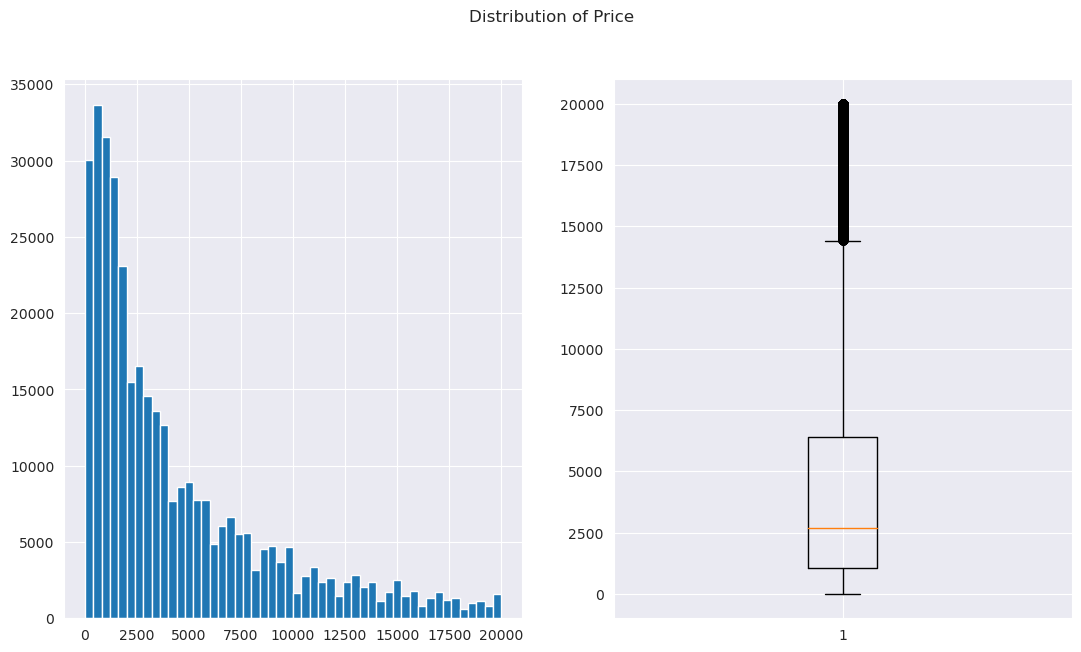

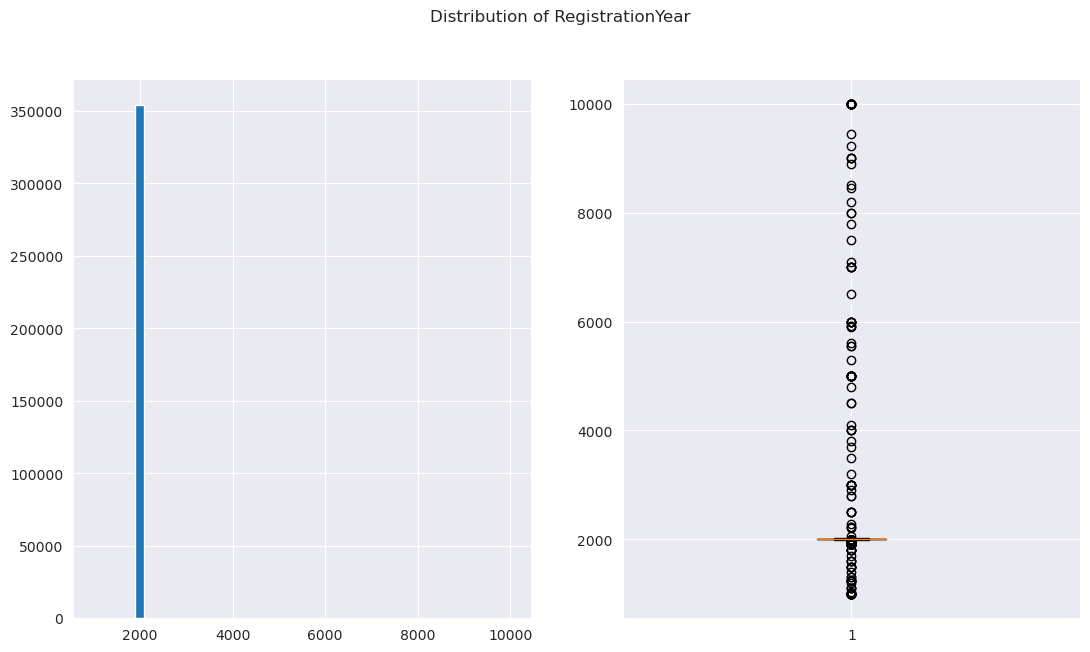

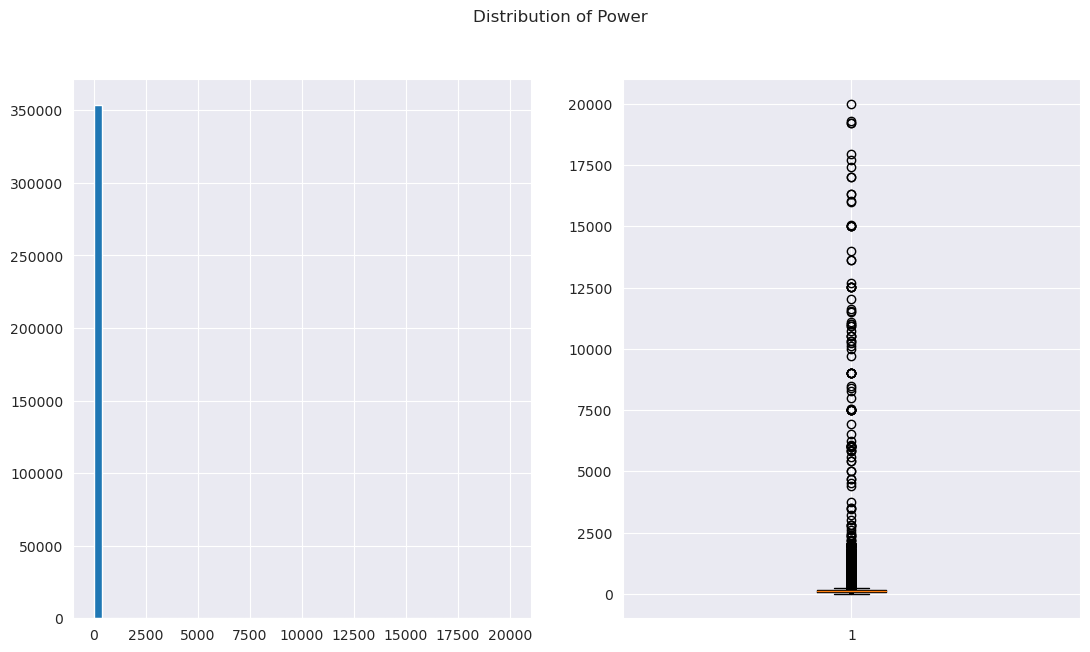

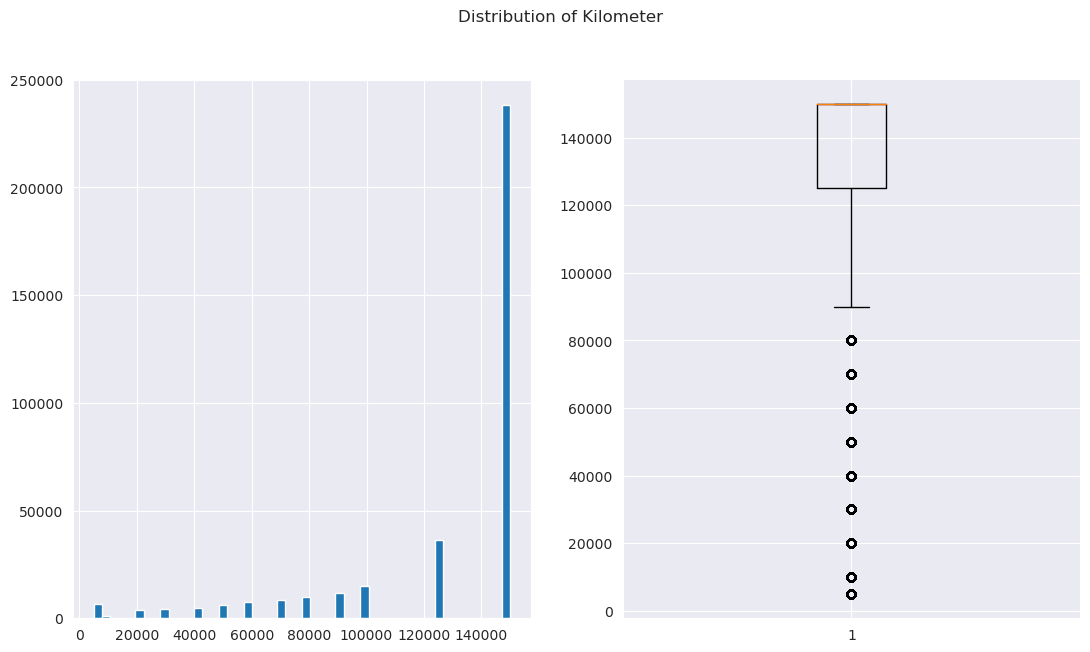

,Price,RegistrationYear,Power,Kilometer
count,354369.000000,354369.000000,354369.000000,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535
std,4514.158514,90.227958,189.850405,37905.341530
min,0.000000,1000.000000,0.000000,5000.000000
25%,1050.000000,1999.000000,69.000000,125000.000000
50%,2700.000000,2003.000000,105.000000,150000.000000
75%,6400.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


In [5]:
def hist_and_boxplot(data, column):
    fig, ax = plt.subplots(1, 2, figsize = (13, 7))
    ax[0].hist(data[column], bins = 50)
    ax[1].boxplot(data[column])
    fig.suptitle(f'Distribution of {column}', size = 12)
    plt.show()

for column in ['Price', 'RegistrationYear', 'Power', 'Kilometer']:
    hist_and_boxplot(data, column)

data.describe()

Выявлены следующие аномалии:

* `Price`: присутствуют нулевые значения, что возможно, но не несет полезности при обучении, поэтому необходимо рассмотреть эти случаи.
* `RegistrationYear`, присутствуют аномально низкие и аномально большие значения, их необходимо удалить.
* `Power`, присутствуют аномально низкие и аномально большие значения, их необходимо удалить.

Столбец `Price`

Посмотрим на распределение значений от `0` до `200`.

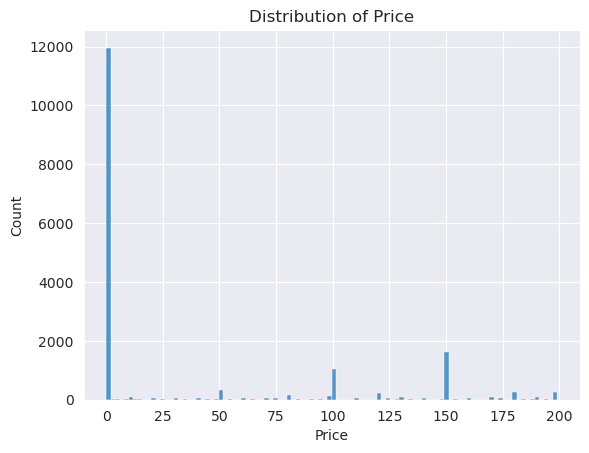

In [6]:
sns.histplot(data.loc[data.Price < 200]['Price'], bins = 100);
plt.title('Distribution of Price');

Объявления со значением цены `0` могут присутствовать в объявлениях, но они не несут какой-то полезной информации, так как либо цена указана в описании, либо пользователь избавляется от металлолома, который не имеет особой ценности. Значения от `0` до `50` тоже входят в эту категорию, поэтому удалим эти данные, чтобы они не мешали обучению. На значении `50` присутствует небольшой пик, поэтому установим порог с этого значения.

In [7]:
print(f'Процент аномальных значений: {round(data.loc[data["Price"] < 50, "Price"].count() / data.shape[0], 3)}')

Процент аномальных значений: 0.035


Процент удаляемых значений мал. Следовательно, можем удалить.

In [8]:
data = data.loc[data["Price"] >= 50]

Столбец `RegistrationYear`

Год регистрации имеет важное значение при оценивании автомобиля, поэтому аномально высокие и аномально низкие значения необходимо удалить. Найдем нижний и верхний порог данных для удаления.

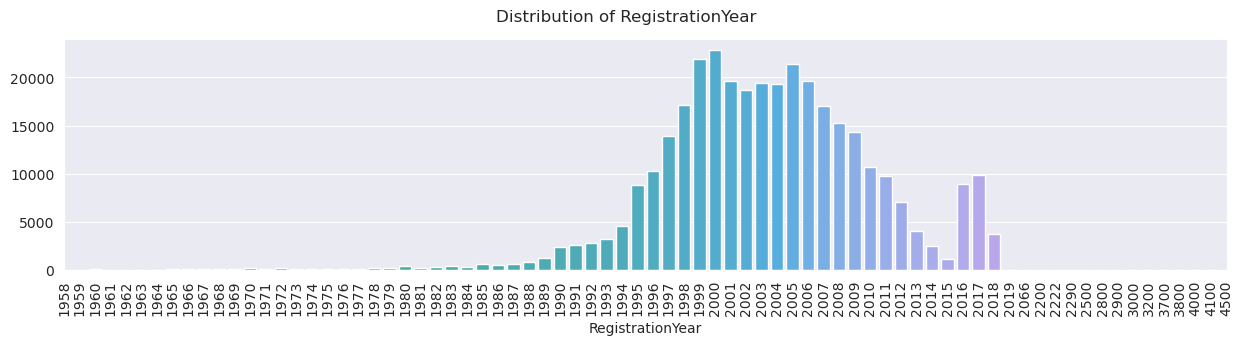

In [9]:
fig, ax = plt.subplots(figsize = (15, 3))

sns.barplot(x = data.groupby('RegistrationYear')['Price'].count().sort_values( ascending=False).index,
            y = data.groupby('RegistrationYear')['Price'].count().sort_values( ascending=False).values,
            ax=ax)

fig.suptitle('Distribution of RegistrationYear')
plt.xticks(rotation = 90)
ax.set_xlim(45, 120);


Видно, что верхний порог находится на значении `2018`, а нижний на `1970`. Посмотрим на уникальные значения за этим порогом и процент удаляемых данных.

In [10]:
print(  f'Уникальные значения RegistrationYear > 2016:\n'
        f'{data.loc[data.RegistrationYear > 2016, "RegistrationYear"].unique()}\n'

        f'Уникальные значения RegistrationYear < 1970:\n'
        f'{data.loc[data.RegistrationYear < 1970, "RegistrationYear"].unique()}\n'

        f'Процент удаляемых данных: {data.loc[(data["RegistrationYear"] > 2016) | (data["RegistrationYear"] < 1970)].shape[0] / data.shape[0]}')


Уникальные значения RegistrationYear > 2016:
[2018 2017 3200 9999 8888 2200 4100 3000 2066 2019 8000 5300 9000 2900
 6000 5900 5911 5000 4000 8500 3700 3800 4800 7000 2290 9450 2500 5555
 5600 2222 2800 4500 7800 7100 8200]
Уникальные значения RegistrationYear < 1970:
[1910 1969 1965 1945 1925 1955 1968 1961 1966 1963 1964 1960 1958 1967
 1956 1000 1941 1500 1962 1929 1957 1940 1949 1937 1951 1800 1959 1953
 1954 1234 1400 1950 1948 1952 1932 1255 1942 1935 1933 1936 1923 1930
 1001 1944 1943 1938 1934 1928 1600 1111 1039 1300 1931 1602 1947 1927
 1946]
Процент удаляемых данных: 0.043381118656162086


Значений меньше одного процента, можем удалять.

In [11]:
data = data.loc[(data.RegistrationYear <= 2016) & (data.RegistrationYear >= 1970)]

Столбец `Power`

Нулевая мощность говорит о том, что, либо пользователь забыл указать параметр, либо в машине нет двигателя или он нерабочий, а мощность больше 1500 о том, что пользователь опечатался, либо произошел сбой. Следовательно, эти данные необходимо удалить. Посмотрим на распределение данных и выявим границы.

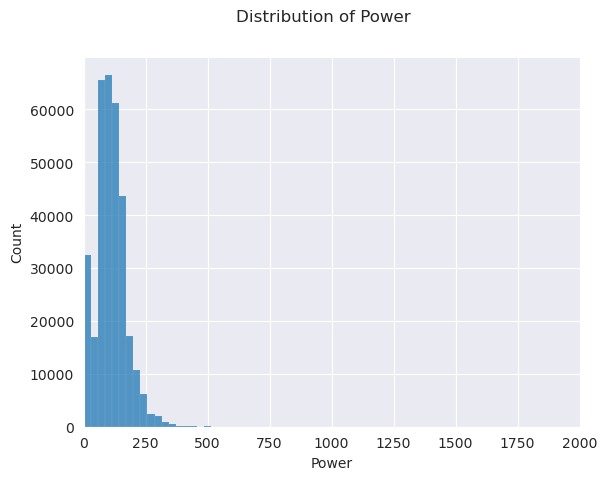

In [12]:
fig, ax = plt.subplots()

sns.histplot(data.Power, ax = ax, bins = 700)

fig.suptitle('Distribution of Power')
ax.set_xlim(0, 2000);

Очевидно, что мощности (<10) и (>2000) не бывает, поэтому такие данные следует удалить.

In [13]:
data = data.loc[(data.Power > 10) | (data.Power < 2000)]

Посмотрим на распределение категориальных признаков.

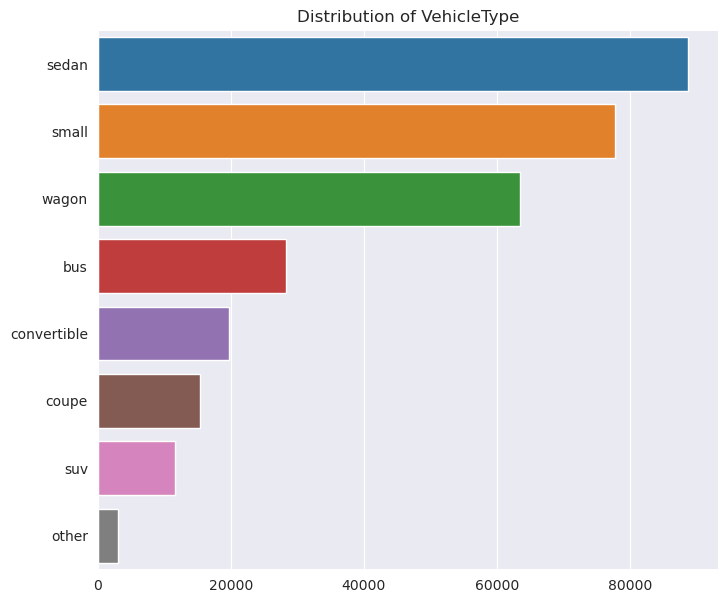

+-------------------------------------------------------------------------------------------+
+-------------------------------------------------------------------------------------------+


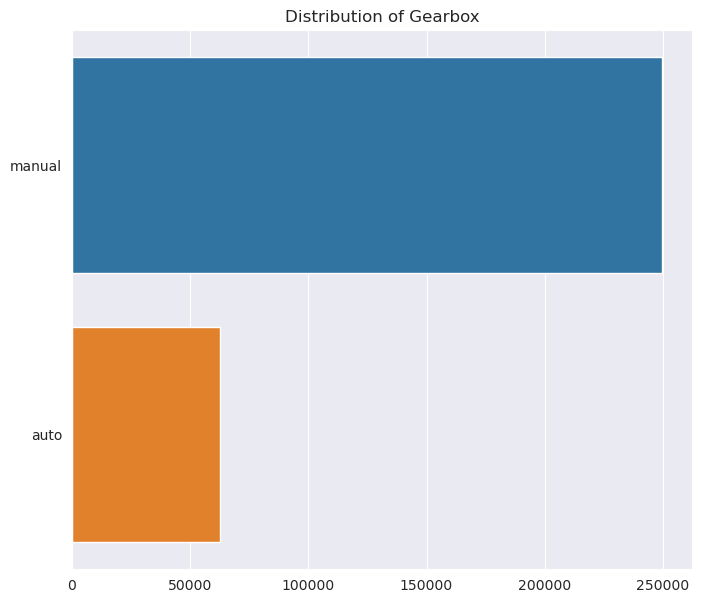

+-------------------------------------------------------------------------------------------+
+-------------------------------------------------------------------------------------------+


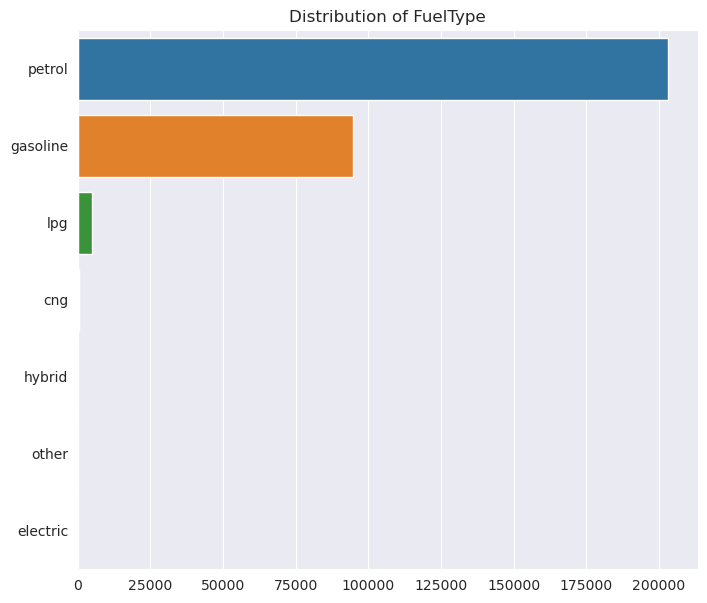

+-------------------------------------------------------------------------------------------+
+-------------------------------------------------------------------------------------------+


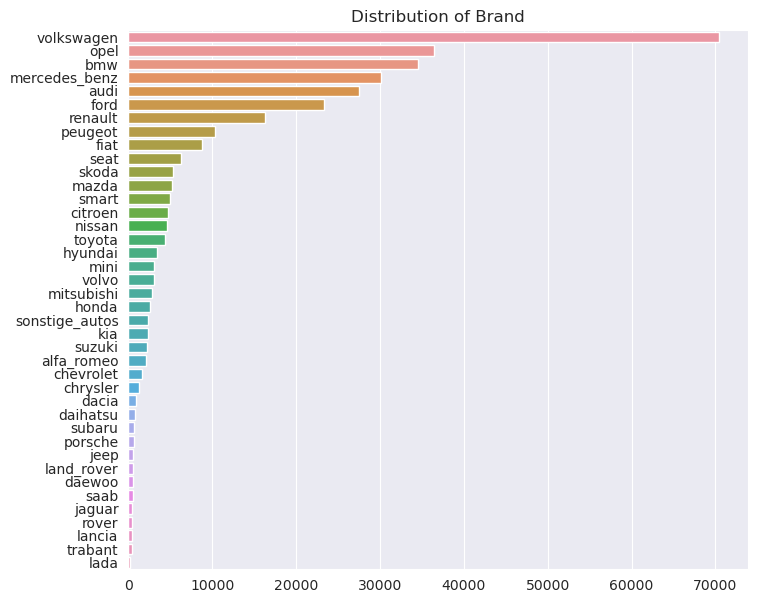

+-------------------------------------------------------------------------------------------+
+-------------------------------------------------------------------------------------------+


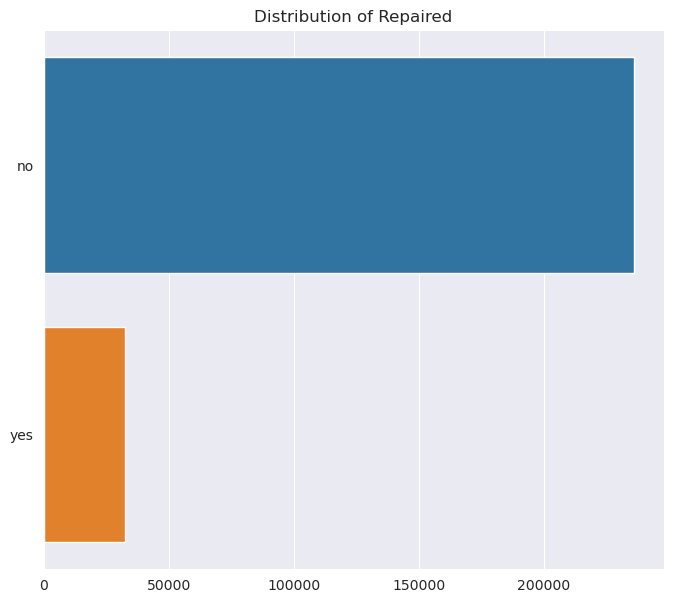

+-------------------------------------------------------------------------------------------+
+-------------------------------------------------------------------------------------------+


In [14]:
for column in ['VehicleType', 'Gearbox', 'FuelType', 'Brand', 'Repaired']:
    plt.figure(figsize=(8, 7))
    plt.title(f'Distribution of {column}')
    sns.barplot(x=data[column].value_counts().values, y=data[column].value_counts().index)
    plt.show()
    print('+-------------------------------------------------------------------------------------------+\n'
          '+-------------------------------------------------------------------------------------------+')


Аномальные значения не выявлены.

В данных имеются пропуски, выведем их.

Repaired            0.1791
FuelType            0.0711
VehicleType         0.0585
Model               0.0457
Gearbox             0.0450
Price               0.0000
RegistrationYear    0.0000
Power               0.0000
Kilometer           0.0000
Brand               0.0000
dtype: float64


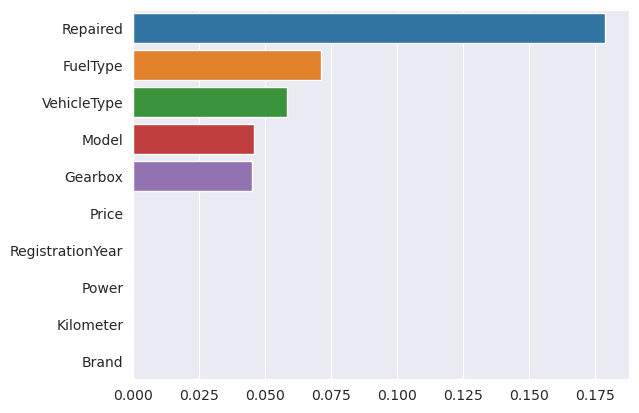

In [15]:
null_values = round(data.isna().sum().sort_values(ascending = False) / data.shape[0], 4)
sns.barplot(y = null_values.index, x = null_values.values);
print(null_values)

Пропуски имеются в столбцах:

* `VehicleType` - 0.10%
* `Gearbox` - 0.05%
* `Model` - 0.05%
* `FuelType` - 0.08%
* `Repaired` - 0.19%.

Столбец `VehicleType`

Сложно определить причину пропуска и возможное значение заполнения, поэтому заполним пропуски самым популярным видом кузова для бренда, который находится в элементе с пропуском.
Для этого найдем для каждого бренда свое значение и запишем в словарь `dict_brand_to_vehicle`.

Напишем функцию для нахождения словарей.

In [16]:
brands = data.Brand.unique()

def dict_of_best_frequency(purpose_column):
    brands_to_column = []

    for brand in brands:
        brands_to_column.append(data.loc[data['Brand'] == brand][purpose_column].value_counts(ascending = False).index[0])

    return dict(zip(brands, brands_to_column))




In [17]:
data.VehicleType = data.VehicleType.fillna(data['Brand'].map(dict_of_best_frequency('VehicleType')))

Столбец `Gearbox`

Процент пропусков - 5%, незначительно, поэтому попробуем заполнить самым часто встречающимся.

In [18]:
data.Gearbox.value_counts()

manual    249736
auto       62667
Name: Gearbox, dtype: int64

Видно, что `manual` превосходит `auto` по количеству в 4 раза, поэтому заменим пропуски значением `manual`.

In [19]:
data.Gearbox = data.Gearbox.fillna('manual')

Столбец `Model`

Воспользуемся принципом заполнения как в столбце `VehicleType`. В процессе заполнения появился бренд `sonstige_autos`, у которого все значения в моделях - Nan, следовательно, поставим заглушку `unknown`.

In [20]:
data.loc[data.Brand == 'sonstige_autos', 'Model'] = 'unknown'

data.Model = data.Model.fillna(data['Brand'].map(dict_of_best_frequency('Model')))

Столбец `FuelType`

Воспользуемся принципом заполнения как в столбце `VehicleType` и `Model`.

In [21]:
data.FuelType = data.FuelType.fillna(data['Brand'].map(dict_of_best_frequency('FuelType')))

Столбец `Repaired`

Пропущенных значений - 20%, слишком много. Удалить данные не можем, сдвинуть в сторону самого частого - тоже, поэтому поставим заглушку `unknown`.

In [22]:
data.Repaired = data.Repaired.fillna('unknown')

Проверим оставшиеся пропуски.

Price               0.0
VehicleType         0.0
RegistrationYear    0.0
Gearbox             0.0
Power               0.0
Model               0.0
Kilometer           0.0
FuelType            0.0
Brand               0.0
Repaired            0.0
dtype: float64


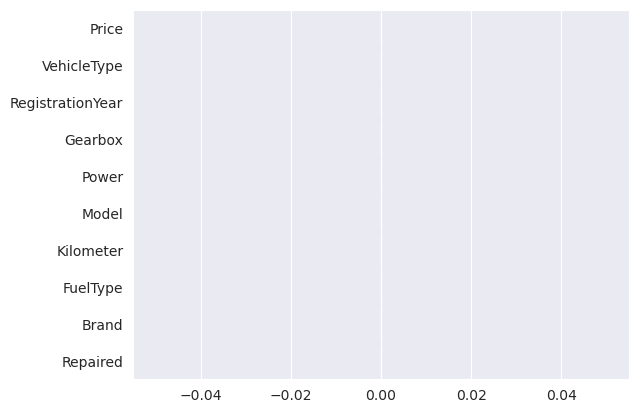

In [23]:
null_values = round(data.isna().sum().sort_values(ascending = False) / data.shape[0], 4)
sns.barplot(y = null_values.index, x = null_values.values)
print(null_values)

Все пропуски удалены.

## Подготовка выборок для обучения

В первую очередь необходимо разделить данные на тренировочную и тестовую выборки.

In [24]:
features = data.drop(['Price'], axis=1)
target = data['Price']

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE
)

Начнем кодирование данных.

1. `Model` - данный столбец имеет высокую мощность, поэтому воспользуемся методом порядкового кодирования.
2. `остальные столбцы` - метод OHE.

In [25]:
ohe_features = features_train.select_dtypes(include='object').columns.to_list()
ohe_features.remove('Model')

num_features = features_train.select_dtypes(exclude='object').columns.to_list()

In [26]:
col_transformer = make_column_transformer(
    (
        OneHotEncoder(drop='first'),
        ohe_features
    ),
    (
        OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
        ['Model']
    ),
    (
        StandardScaler(),
        num_features
    ),
    remainder='passthrough'
)
features_train = pd.DataFrame.sparse.from_spmatrix(
    col_transformer.fit_transform(features_train))

features_test = pd.DataFrame.sparse.from_spmatrix(
    col_transformer.fit_transform(features_test))

## Обучение разных моделей

Обучим разные модели.

**Простые модели:**
1. LinearRegression
2. DecisionTreeRegressor
3. RandomForestRegressor

**Модели на основе градиентного бустинга:**

1. LightGBM
2. CatBoost

Подготовим словари параметров для каждой модели.

In [27]:
param_grid_forest = {
    'n_estimators': range(1, 101, 20),
    'max_depth': range(2, 6),
    'min_samples_leaf': range(1,5,2),
    'min_samples_split': range(2,6,2)
}

param_grid_tree = {
    'max_depth': range(2, 6),
    'min_samples_leaf': range(1,5,2),
    'min_samples_split': range(2,6,2)
}

param_grid_catboost = {
    'n_estimators' : range(1, 100, 25),
    'learning_rate': [0.03, 0.1],
    'depth': range(2, 6)
}

param_grid_lightgbm = {
    'n_estimators' : range(1, 100, 25),
    'learning_rate': [0.1, 0.01]
}

### Простые модели

Создадим модели, и подберем параметры с помощью `GridSearchCV`.

In [37]:
model_TREE = DecisionTreeRegressor(random_state=RANDOM_STATE)
model_FOREST = RandomForestRegressor(random_state=RANDOM_STATE)
model_LINREGR = LinearRegression()

In [38]:
%%time

grid_TREEE = GridSearchCV(model_TREE, param_grid_tree, cv = 3, scoring='neg_mean_squared_error')
grid_TREEE.fit(features_train, target_train)

grid_FOREST = GridSearchCV(model_FOREST, param_grid_forest, cv = 3, scoring='neg_mean_squared_error')
grid_FOREST.fit(features_train, target_train)

print('Время подбора:\n')

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015934 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011554 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013549 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005333 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing

Модели обучены. Выведем подобранные параметры.

In [39]:
print(
    f'Модель DecisionTreeRegressor\n {grid_TREEE.best_params_}\n\n'
    f'Модель RandomForestRegressor\n {grid_FOREST.best_params_}'
)

Модель DecisionTreeRegressor
 {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}

Модель RandomForestRegressor
 {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 81}


### Модели на основе градиентного бустинга

Создадим модели, и подберем параметры с помощью `GridSearchCV`.

In [40]:
model_catboost = cb.CatBoostRegressor(random_state=RANDOM_STATE)
model_lightgbm = lgb.LGBMRegressor(random_state=RANDOM_STATE)

In [41]:
%%time

grid_catboost = GridSearchCV(estimator=model_catboost, param_grid=param_grid_catboost, cv = 3, n_jobs=-1)
grid_catboost.fit(features_train, target_train, verbose = False)

grid_lightgbm = GridSearchCV(estimator=model_lightgbm, param_grid=param_grid_lightgbm, cv = 3, n_jobs=-1)
grid_lightgbm.fit(features_train, target_train, verbose = False)

print('Время подбора:\n')

Время подбора:

CPU times: user 12.2 s, sys: 1.39 s, total: 13.5 s
Wall time: 1min 11s


Модели обучены. Выведем подобранные параметры.

In [42]:
print(
    f'Модель CatBoostRegressor\n {grid_catboost.best_params_}\n\n'
    f'Модель LGBMRegressor\n {grid_lightgbm.best_params_}'
)

Модель CatBoostRegressor
 {'depth': 5, 'learning_rate': 0.1, 'n_estimators': 76}

Модель LGBMRegressor
 {'learning_rate': 0.1, 'n_estimators': 76}


## Анализ времени обучения

Для анализа времени обучения - создадим класс `Time`.

In [32]:
class Time:
    def __init__(self, model, model_name = ''):
        self.model = model
        self.model_name = model_name
        self.cross_val_scores = None
        self.train_time = None
        self.predict_time = None
        self.rmse = None

    def set_fit_time(self, features_time, target_time):
        start = time.time()
        self.model.fit(features_time, target_time)
        finish = time.time()
        self.train_time = finish - start

    def set_predict_time(self, features_time, target_time):
        start = time.time()
        self.cross_val_scores = cross_val_score(self.model, features_time, target_time, scoring = 'neg_mean_squared_error', cv = 10, n_jobs = -1 )
        end = time.time()
        self.predict_time = end - start

    def set_quality(self):
        self.rmse = np.mean(np.abs(self.cross_val_scores)**.5)


Создадим экземпляры класса для каждой модели.

In [33]:
model_TREE_time = Time(DecisionTreeRegressor(max_depth=5, random_state=RANDOM_STATE), 'DecisionTreeRegressor')
model_FOREST_time = Time(RandomForestRegressor(max_depth=5, n_estimators=61, random_state=RANDOM_STATE), 'RandomForestRegressor')
model_LINREGR_time = Time(LinearRegression(), 'LinearRegression')
model_catboost_time = Time(cb.CatBoostRegressor(depth=5, learning_rate=0.1, n_estimators=76, random_state=RANDOM_STATE, verbose=False), 'CatBoostRegressor')
model_lightgbm_time = Time(lgb.LGBMRegressor(learning_rate=0.1, n_estimators=76, random_state=RANDOM_STATE, verbose = 0), 'LGBMRegressor')

exemplars_time_models = [model_TREE_time, model_FOREST_time, model_LINREGR_time, model_catboost_time, model_lightgbm_time]
for model in exemplars_time_models:
    model.set_fit_time(features_train, target_train)
    model.set_predict_time(features_train, target_train)
    model.set_quality()

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005805 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


Составим таблицу качества и времени обучения. Для этого напишем функцию.

In [34]:
def print_table():
    print('|{: >23}|{: >18}|{: >18}|{: >12}|'.format('Модель', 'Время обучения', 'Время предсказания', 'RMSE'))
    for model in exemplars_time_models:
        print('|{: >23}|{: >18.5f}|{: >18.5f}|{: >12.5f}|'.format(model.model_name, model.train_time, model.predict_time, model.rmse))

In [35]:
print_table()

|                 Модель|    Время обучения|Время предсказания|        RMSE|
|  DecisionTreeRegressor|           0.39625|           5.03500|  2422.49067|
|  RandomForestRegressor|          17.55792|          76.65280|  2386.50055|
|       LinearRegression|           0.33671|           4.08055|  2948.26254|
|      CatBoostRegressor|           0.61106|          15.01666|  1913.29942|
|          LGBMRegressor|           0.50267|           6.33343|  1726.79243|


## Тестирование лучшей модели

Протестируем модель на тестовой выборке.

In [36]:
for model in exemplars_time_models:
    model.set_predict_time(features_test, target_test)
    model.set_quality()

print_table()

|                 Модель|    Время обучения|Время предсказания|        RMSE|
|  DecisionTreeRegressor|           0.39625|           0.73778|  2427.12007|
|  RandomForestRegressor|          17.55792|          10.80073|  2386.66925|
|       LinearRegression|           0.33671|           1.03922|  2970.17409|
|      CatBoostRegressor|           0.61106|           5.22203|  1923.59685|
|          LGBMRegressor|           0.50267|           1.37391|  1738.76390|


## Вывод

Критерии, которые важны заказчику:

* качество предсказания;
* время обучения модели;
* время предсказания модели.

Исходя из того, следует отдать предпочтение LightGBM, т.к. она имеет лучшее качество предсказания. Catboost тем не менее показывает результаты лучше LightGBM во времени предсказания и почти не отстает в качестве. Но, если учитывать приоритетность заказчика, то стоит отдать предпочтение **LightGBM**.